In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import math

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, BatchNormalization
from keras.callbacks import EarlyStopping

import datetime as dt

Using TensorFlow backend.
C:\tools\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\tools\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\tools\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\tools\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Pas

In [3]:
path = "C:/Studia/Magisterka/Faints-Prediction/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt").values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt").values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt").values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [4]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])

HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])

In [5]:
def shift(xs, n):
    if n >= 0:
        return np.concatenate((np.full(n, np.nan), xs[:-n]))
    else:
        return np.concatenate((xs[-n:], np.full(-n, np.nan)))

part_to_drop = 0.4
BP_data_scaled_trimmed = BP_data_scaled.copy()
HR_data_scaled_trimmed = HR_data_scaled.copy()
for col in BP_data_scaled_trimmed:
    n_rows_to_drop = int(part_to_drop * np.count_nonzero(~np.isnan(BP_data_scaled_trimmed[col])))

    BP_data_scaled_trimmed[col] = shift(BP_data_scaled_trimmed[col], -n_rows_to_drop)
    HR_data_scaled_trimmed[col] = shift(HR_data_scaled_trimmed[col], -n_rows_to_drop)

In [10]:
def series_to_supervised(share_prices, timestamps, input_time_steps, dropnan=True):
    share_prices_df = pd.DataFrame(share_prices)
    timestamps_df = pd.DataFrame(timestamps)
    share_prices_timeseries = list()
    timestamps_timeseries = list()
    
    for i in range(input_time_steps-1, -1, -1):
        share_prices_timeseries.append(share_prices_df.shift(i))
        timestamps_timeseries.append(timestamps_df.shift(i))
    
    aggregated_share_prices = pd.concat(share_prices_timeseries, axis=1)
    aggregated_timestamps = pd.concat(timestamps_timeseries, axis=1)
    
    if dropnan:
        aggregated_share_prices.dropna(inplace=True)
        aggregated_timestamps.dropna(inplace=True)

    aggregated_timestamps = aggregated_timestamps.values
    aggregated_share_prices = aggregated_share_prices.values
    
    not_overlapping_indexes = range(0, 
                                    len(aggregated_share_prices), 
                                    input_time_steps)
    
    aggregated_timestamps = aggregated_timestamps[not_overlapping_indexes]
    aggregated_share_prices = aggregated_share_prices[not_overlapping_indexes]
    return aggregated_share_prices, aggregated_timestamps
    
def split(BP_data, HR_data):
    X = []
    y = []
    for col in BP_data:
        BP_supervised, HR_supervised = series_to_supervised(BP_data[col], HR_data[col], 128)
        for BP_interval, HR_interval in zip(BP_supervised, HR_supervised):
            BP_HR_interval = []
            for BP_time_step, HR_time_step in zip(BP_interval, HR_interval):
                BP_HR_interval.append([BP_time_step, HR_time_step])
            X.append(BP_HR_interval)
            if labels[col] == 'Synkope': label = [0., 1.] 
            else: label = [1., 0.]
            y.append(label)
    return np.array(X), np.array(y)

In [11]:
X_train, y_train = split(BP_data_scaled_trimmed[train_indices], HR_data_scaled_trimmed[train_indices])
X_test, y_test = split(BP_data_scaled_trimmed[test_indices], HR_data_scaled_trimmed[test_indices])
X_validation, y_validation = split(BP_data_scaled_trimmed[validation_indices], HR_data_scaled_trimmed[validation_indices])

In [12]:
y_train.shape

(2531, 2)

In [13]:
X_train.shape

(2531, 128, 2)

In [28]:
from vrae.vrae import VRAE
from torch.utils.data import TensorDataset
import torch

In [29]:
hidden_size = 90
hidden_layer_depth = 1
latent_length = 2
batch_size = 32
learning_rate = 0.0005
n_epochs = 40
dropout_rate = 0.2
optimizer = 'Adam'  # options: ADAM, SGD
cuda = False  # options: True, False
print_every = 30
clip = True  # options: True, False
max_grad_norm = 5
loss = 'MSELoss'  # options: SmoothL1Loss, MSELoss
block = 'LSTM'  # options: LSTM, GRU

In [31]:
train_dataset = TensorDataset(torch.from_numpy(X_train))
test_dataset = TensorDataset(torch.from_numpy(X_test))

In [33]:
sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]


vrae = VRAE(sequence_length=sequence_length,
            number_of_features=number_of_features,
            hidden_size=hidden_size,
            hidden_layer_depth=hidden_layer_depth,
            latent_length=latent_length,
            batch_size=batch_size,
            learning_rate=learning_rate,
            n_epochs=n_epochs,
            dropout_rate=dropout_rate,
            optimizer=optimizer,
            cuda=cuda,
            print_every=print_every,
            clip=clip,
            max_grad_norm=max_grad_norm,
            loss=loss,
            block=block,
            dload='a')


C:\tools\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
C:\tools\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [38]:
vrae.fit(train_dataset)

Epoch: 0
Batch 30, loss = 159.0261, recon_loss = 158.9233, kl_loss = 0.1028
Batch 60, loss = 82.2710, recon_loss = 81.8032, kl_loss = 0.4678
Average loss: 485.2546
Epoch: 1
Batch 30, loss = 98.1383, recon_loss = 97.9735, kl_loss = 0.1648
Batch 60, loss = 105.3430, recon_loss = 105.2195, kl_loss = 0.1235
Average loss: 112.2723
Epoch: 2
Batch 30, loss = 112.5573, recon_loss = 112.5176, kl_loss = 0.0396
Batch 60, loss = 118.9812, recon_loss = 118.4066, kl_loss = 0.5747
Average loss: 110.9785
Epoch: 3
Batch 30, loss = 88.8119, recon_loss = 88.4755, kl_loss = 0.3364
Batch 60, loss = 116.0835, recon_loss = 115.6758, kl_loss = 0.4077
Average loss: 108.5017
Epoch: 4
Batch 30, loss = 80.5247, recon_loss = 80.0955, kl_loss = 0.4292
Batch 60, loss = 167.2363, recon_loss = 165.7493, kl_loss = 1.4870
Average loss: 107.7328
Epoch: 5
Batch 30, loss = 64.7096, recon_loss = 64.0814, kl_loss = 0.6282
Batch 60, loss = 63.6841, recon_loss = 62.8998, kl_loss = 0.7843
Average loss: 84.4192
Epoch: 6
Batch 30

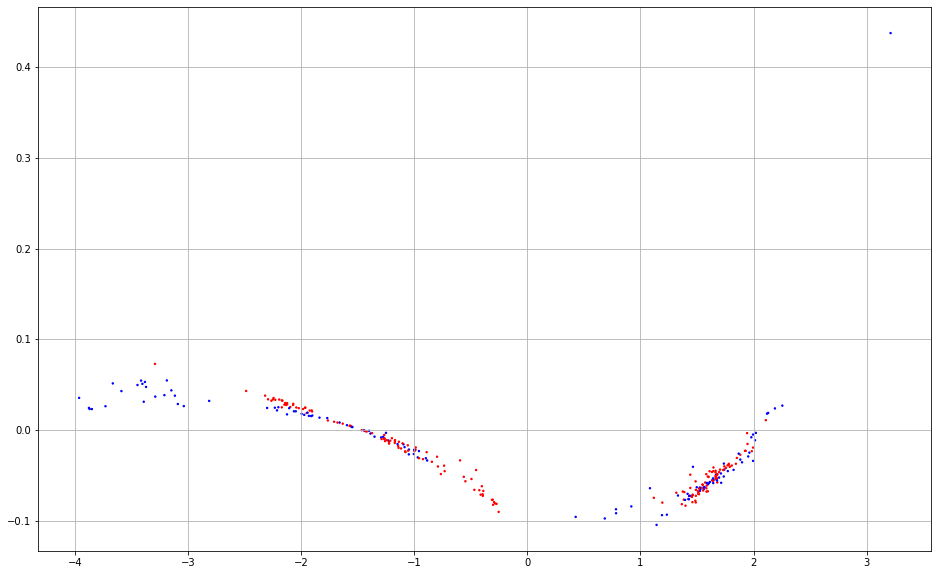

In [161]:
def choose_color(label):
    if label[0] == 1.0:
        return 'r'
    elif label[0] == 0.0:
        return 'b'
    else:
        return 'm'

latent_space = None
def plot_latent_space(X, y):
    global latent_space 
    latent_space = vrae.transform(X)
    plt.figure(figsize=(16,10))
    colors = [choose_color(y) for y in y[:latent_space.shape[0]]]
    plt.scatter(latent_space[:, 0], latent_space[:, 1], c=colors, s=2)
    plt.grid()

plot_latent_space(test_dataset, y_test)

In [53]:
X_test.shape

(303, 128, 2)

In [153]:
latent_space.shape

(288, 2)

In [156]:
X_right_cluster = X_test[np.where(np.all([latent_space[:,0] > 1.5, latent_space[:,0] < 2.0], axis=0))]
X_center_cluster = X_test[np.where(np.all([latent_space[:,0] > -1.5, latent_space[:,0] < -1.0], axis=0))]
X_left_cluster = X_test[np.where(np.all([latent_space[:,0] > -5.0, latent_space[:,0] < -3.0], axis=0))]

In [157]:
X_right_cluster.shape

(86, 128, 2)

In [166]:
def plot_single_time_series(timeseries_list, n=1, color='r', ts_type=1):
    for i in range(n):
        timeseries = timeseries_list[i]
        ts = timeseries[:,ts_type]
        plt.plot(range(len(ts)), ts, c=color)

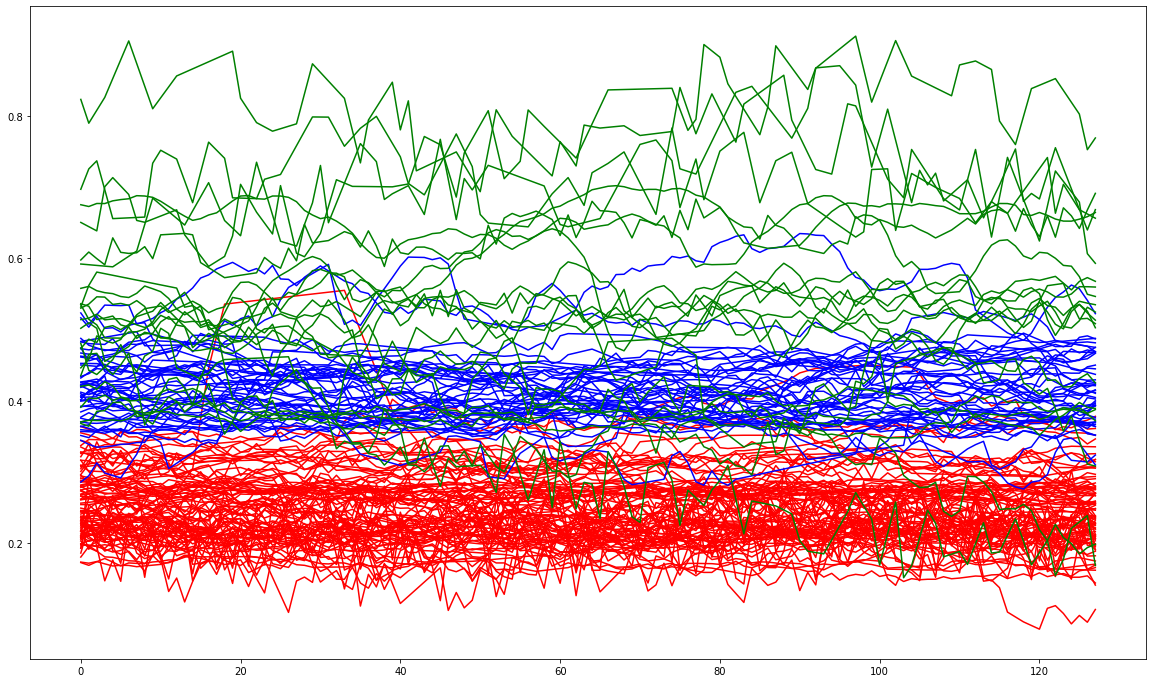

In [167]:
plt.figure(figsize=(20,12))
plot_single_time_series(X_right_cluster, len(X_right_cluster), 'r')
plot_single_time_series(X_center_cluster, len(X_center_cluster), 'b')
plot_single_time_series(X_left_cluster, len(X_left_cluster), 'g')

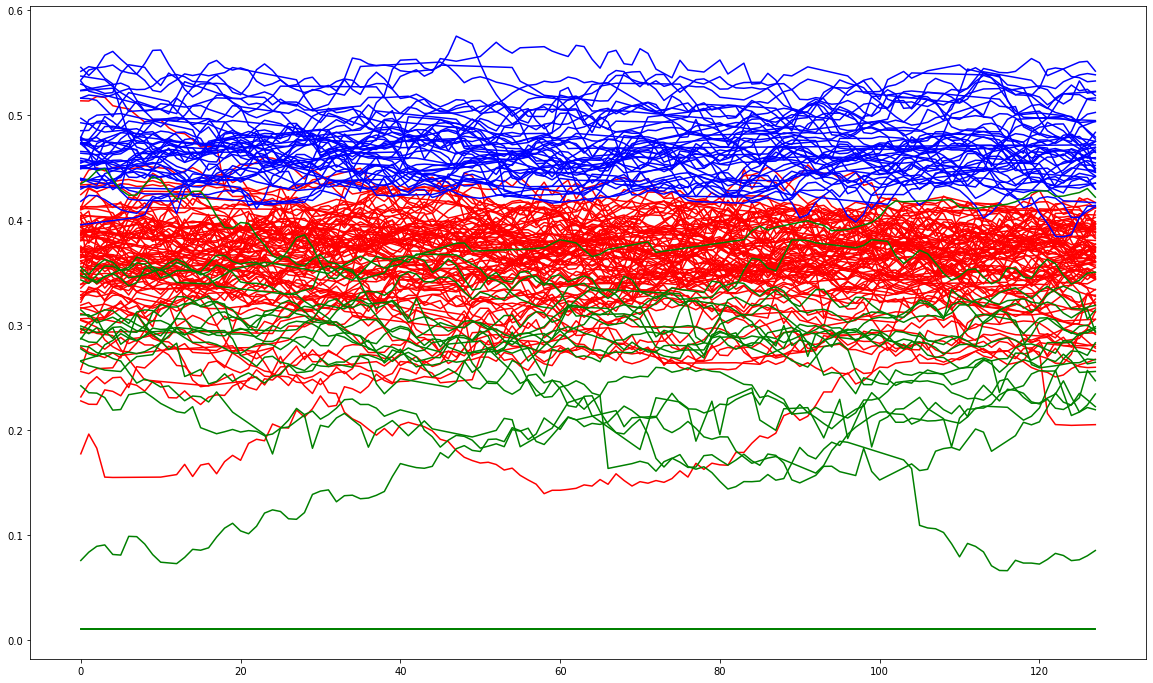

In [168]:
plt.figure(figsize=(20,12))
plot_single_time_series(X_right_cluster, len(X_right_cluster), 'r', 0)
plot_single_time_series(X_center_cluster, len(X_center_cluster), 'b', 0)
plot_single_time_series(X_left_cluster, len(X_left_cluster), 'g', 0)

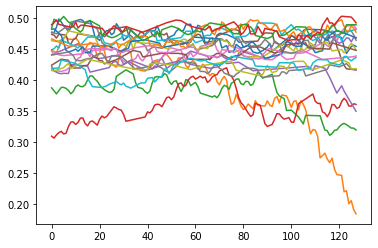

In [127]:
plot_single_time_series(X_center_cluster, 20)

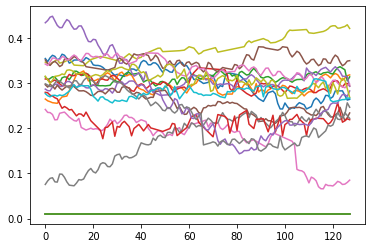

In [128]:
plot_single_time_series(X_left_cluster, 20)

In [ ]:
interwaly - 32/64/128
warstwy - 1/2/3/4
liczba cellek - 1, 16, 32, 128, 256
dense layer neurons - 5,20,100

In [163]:
validation_indices

['158',
 '460',
 '606',
 '320',
 '1',
 '658',
 '559',
 '92',
 '538',
 '675',
 '419',
 '295',
 '393',
 '409',
 '501',
 '375',
 '286']

In [164]:
y_val_pred = model.predict(X_validation)

In [197]:
labels['320']

'Nosynkope'

In [201]:
def split2(BP_data, HR_data, col):
    X = []
    y = []

    BP_supervised, HR_supervised = series_to_supervised(BP_data[col], HR_data[col], 32)
    for BP_interval, HR_interval in zip(BP_supervised, HR_supervised):
        BP_HR_interval = []
        for BP_time_step, HR_time_step in zip(BP_interval, HR_interval):
            BP_HR_interval.append([BP_time_step, HR_time_step])
        X.append(BP_HR_interval)
        if labels[col] == 'Synkope': label = [0., 1.] 
        else: label = [1., 0.]
        y.append(label)
    return np.array(X), np.array(y)

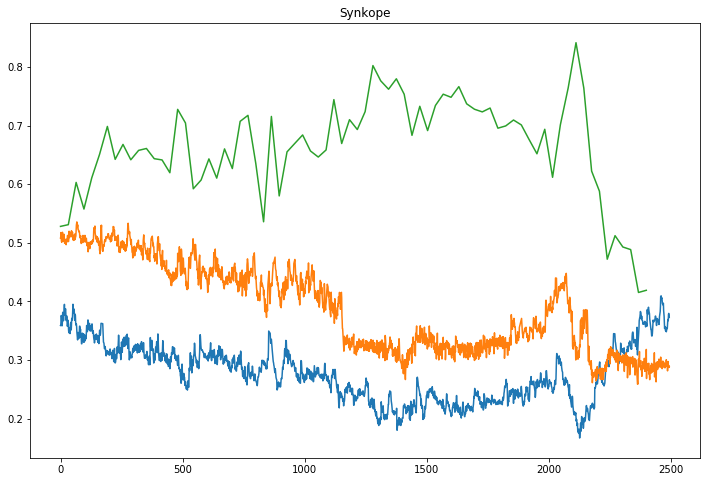

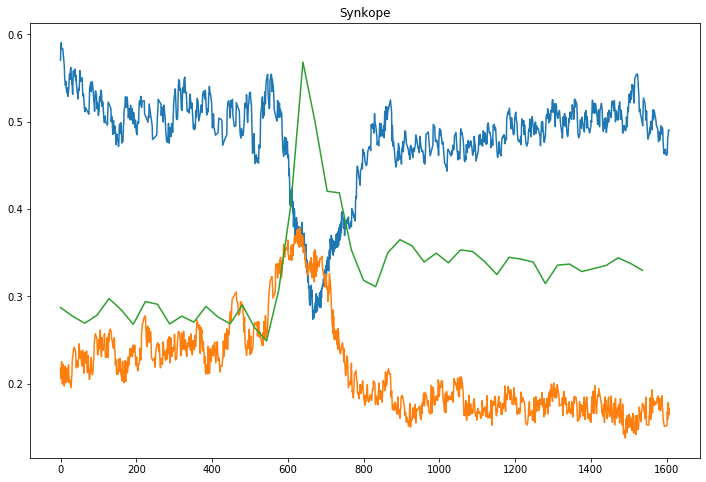

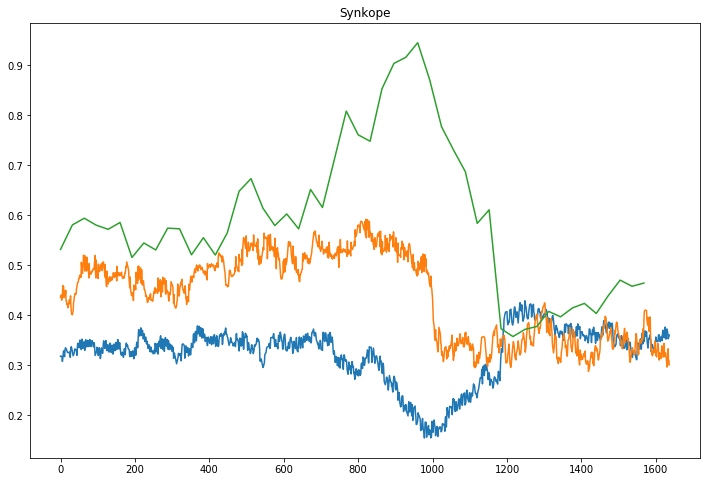

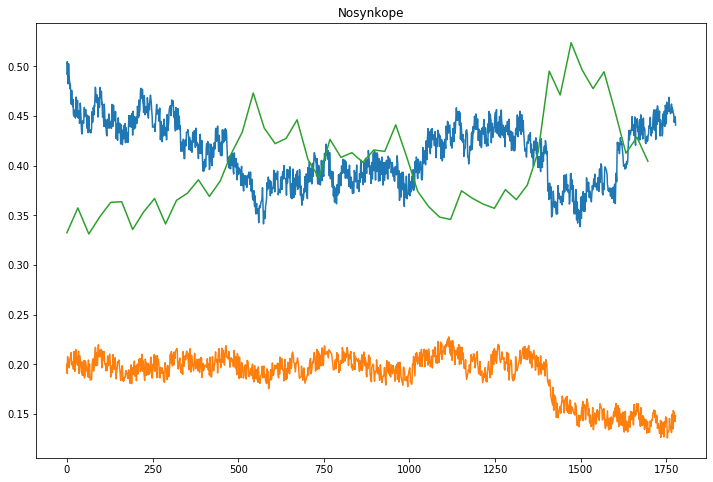

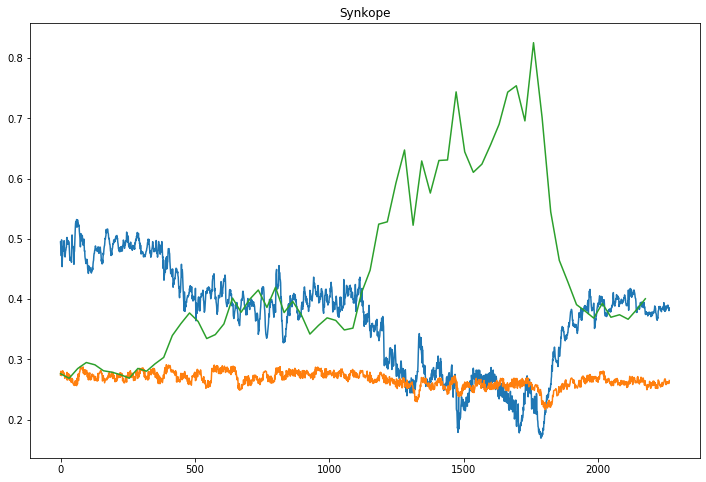

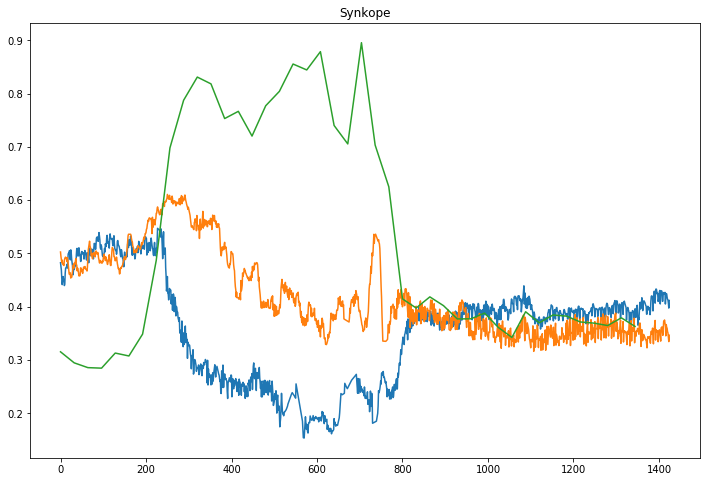

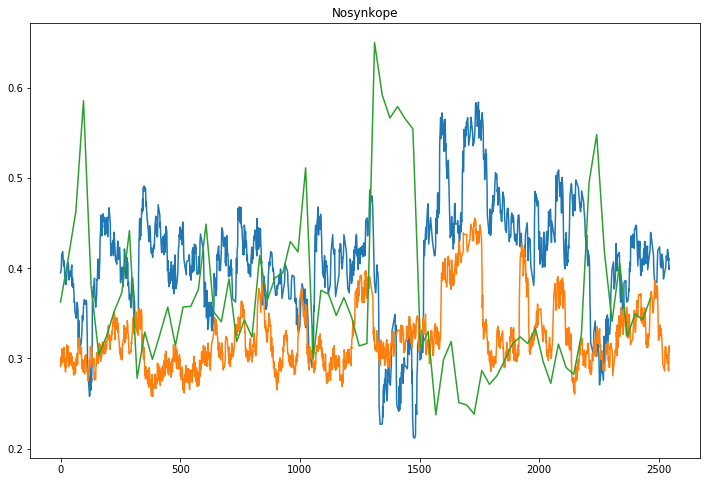

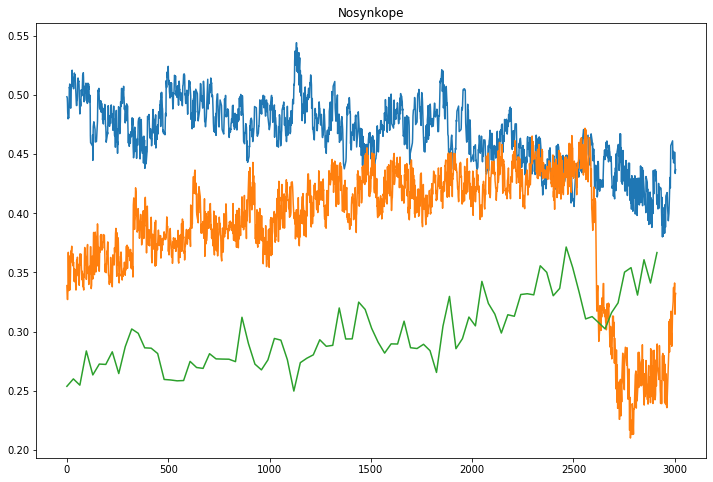

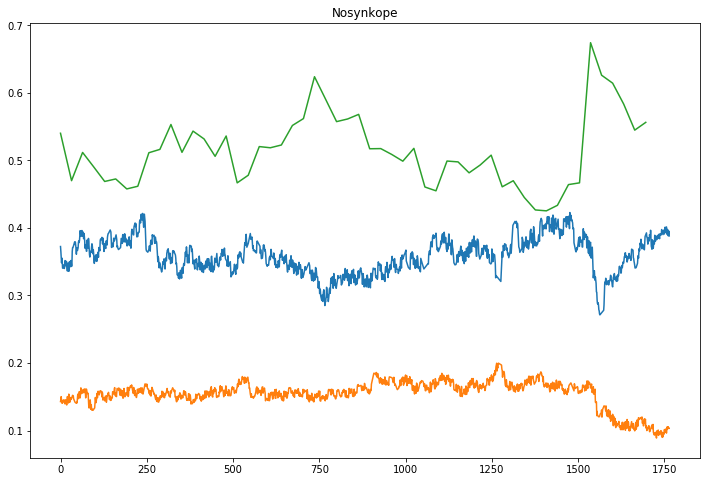

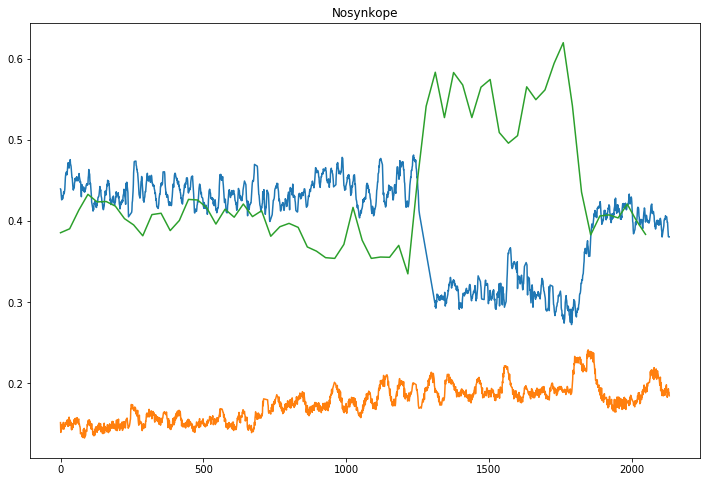

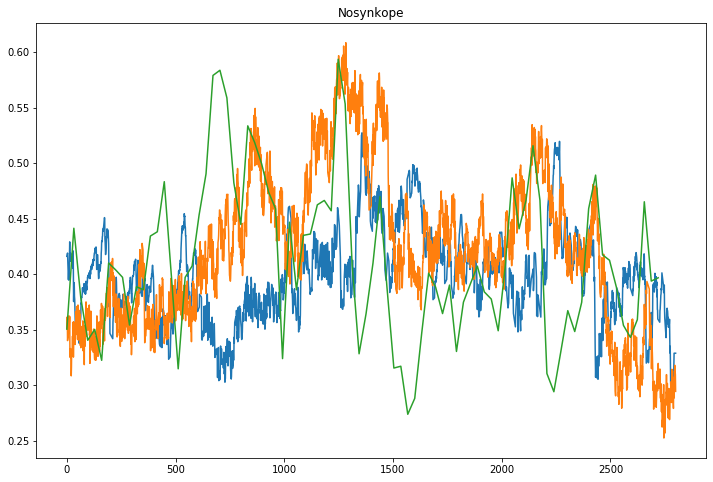

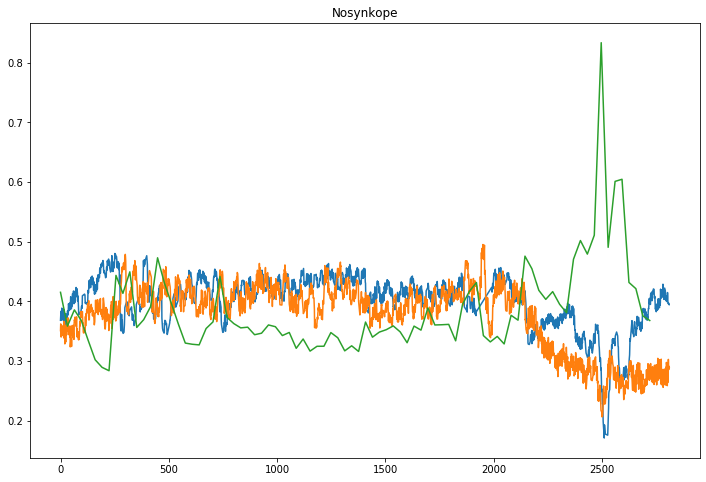

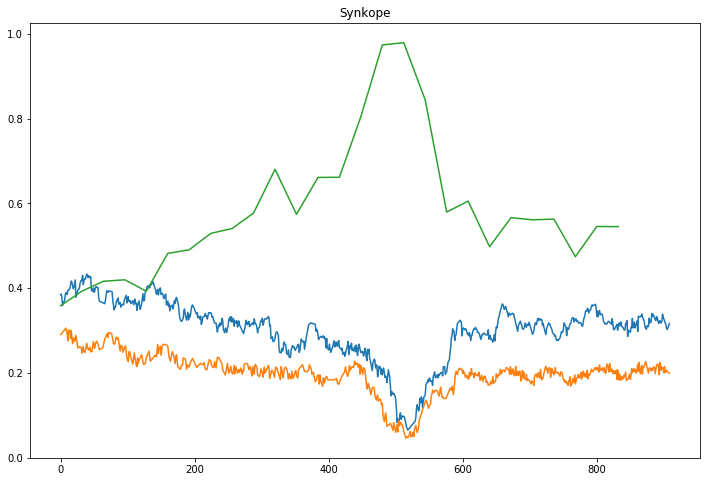

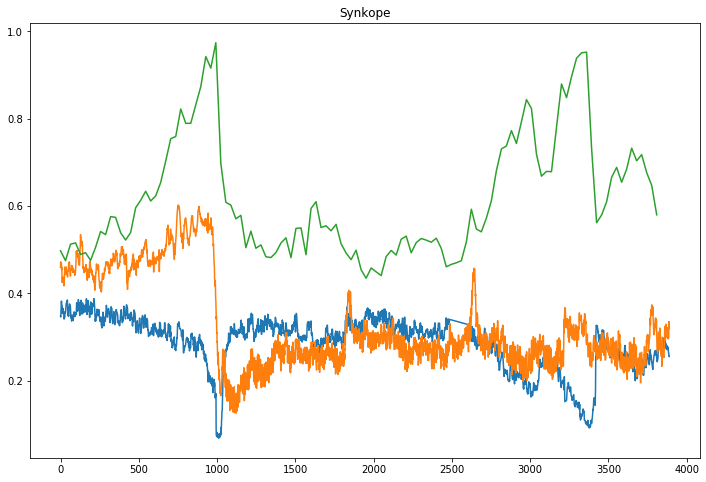

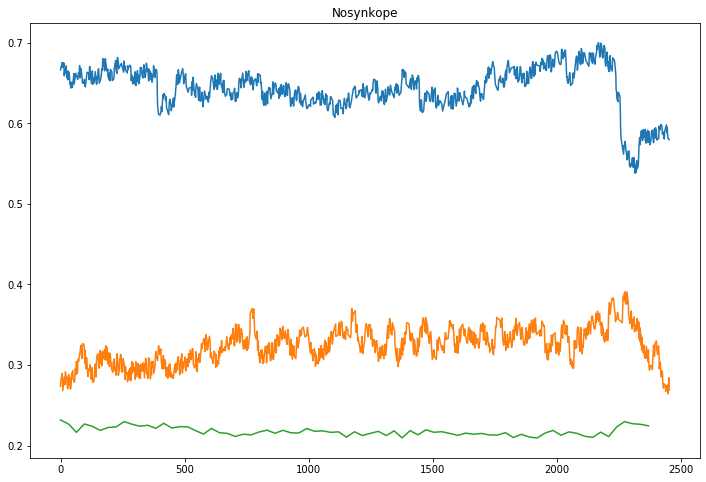

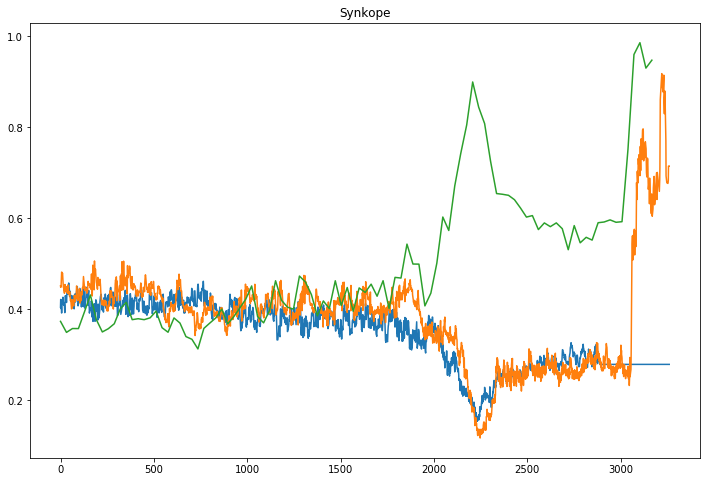

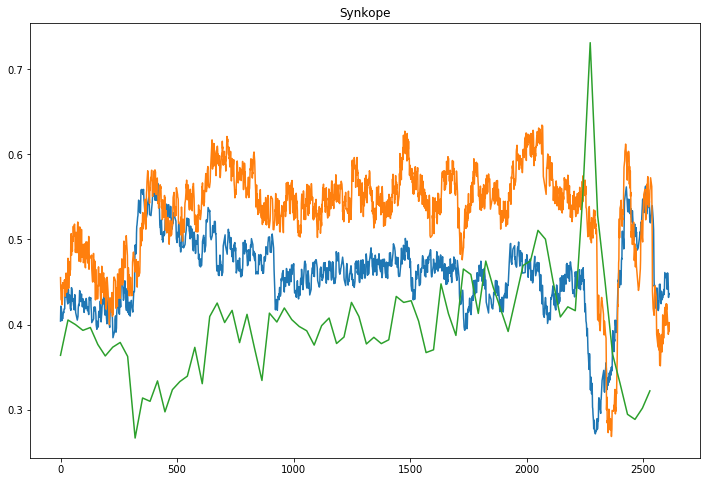

In [220]:
for ind in validation_indices:
    plt.figure(figsize=(12,8))
    X_val, y_val = split2(BP_data_scaled_trimmed, HR_data_scaled_trimmed, ind)
    y_val_pred = model.predict(X_val)

    bp = BP_data_scaled_trimmed[ind].dropna().tolist()
    hr = HR_data_scaled_trimmed[ind].dropna().tolist()
    mult = int(len(bp) / 32 - 1)

    plt.title(labels[ind])
    plt.plot(bp)
    plt.plot(hr)
    plt.plot(range(0, mult*32, 32), y_val_pred[:mult, 1])

In [185]:
y_val_pred[:76,1]

array([0.5279384 , 0.5308761 , 0.6029241 , 0.55750763, 0.6106811 ,
       0.65082186, 0.69840604, 0.64226943, 0.6677257 , 0.6415373 ,
       0.6575933 , 0.6608137 , 0.64340866, 0.6412838 , 0.61945075,
       0.7275223 , 0.7042788 , 0.5920978 , 0.60700274, 0.64305276,
       0.6102672 , 0.6601098 , 0.62656873, 0.70709085, 0.717319  ,
       0.6354274 , 0.5357977 , 0.71544105, 0.57990223, 0.6550066 ,
       0.66951925, 0.68387425, 0.65659237, 0.6462088 , 0.6582767 ,
       0.7441439 , 0.66930133, 0.70996684, 0.6931092 , 0.7236084 ,
       0.80223256, 0.77614176, 0.76188534, 0.77967477, 0.75337756,
       0.68322676, 0.73278165, 0.6913429 , 0.7340976 , 0.75342387,
       0.74812376, 0.76629406, 0.7370123 , 0.72775656, 0.7232067 ,
       0.72979575, 0.69541276, 0.69927627, 0.7093683 , 0.7009839 ,
       0.67595434, 0.65175253, 0.6935523 , 0.6116682 , 0.7013234 ,
       0.7641593 , 0.84124845, 0.76382214, 0.622255  , 0.5879328 ,
       0.47197452, 0.5120905 , 0.49277046, 0.48835915, 0.41524

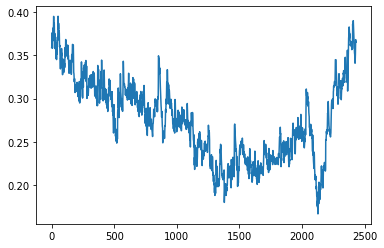

In [181]:
BP_cum = np.array([])
for i in range(76):
    BP_cum = np.concatenate((BP_cum, X_validation[i][:,0]))
plt.plot(BP_cum)

In [175]:
(HR_data_scaled_trimmed['158'])

1       0.507994
2       0.510450
3       0.517496
4       0.507229
5       0.502322
6       0.500817
7       0.503632
8       0.508453
9       0.517914
10      0.507586
11      0.507229
12      0.502725
13      0.506822
14      0.508045
15      0.514631
16      0.506772
17      0.501921
18      0.499119
19      0.501971
20      0.506010
21      0.500317
22      0.503178
23      0.497577
24      0.496734
25      0.506010
26      0.500717
27      0.503934
28      0.503178
29      0.508045
30      0.512561
          ...   
8447         NaN
8448         NaN
8449         NaN
8450         NaN
8451         NaN
8452         NaN
8453         NaN
8454         NaN
8455         NaN
8456         NaN
8457         NaN
8458         NaN
8459         NaN
8460         NaN
8461         NaN
8462         NaN
8463         NaN
8464         NaN
8465         NaN
8466         NaN
8467         NaN
8468         NaN
8469         NaN
8470         NaN
8471         NaN
8472         NaN
8473         NaN
8474         N

In [146]:
len(pred)

1221

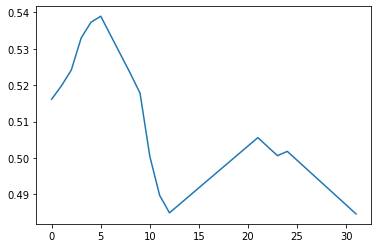

In [138]:
plt.plot(X_train[2134][:, 0])

In [95]:
np.array(X_validation).shape

(1221, 32, 2)

In [62]:
y2 = np.array(y).reshape(12832, 1)

In [68]:
np.unique(y2)

array([0, 1])

In [ ]:
a = [[1,2],[3,4],[5,6]]
b = 

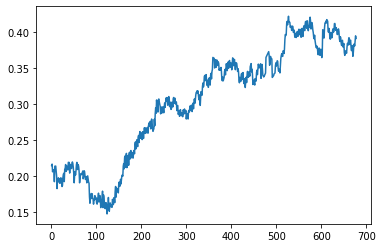

In [21]:
plt.plot(BP_data_scaled_trimmed['187'])
plt.show()

In [22]:
labels['187']

'Synkope'

In [17]:
y,x = series_to_supervised([2,4,6,8,10,12,14,16,18,20], [1,2,3,4,5,6,7,8,9,10], 3)
x

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [18]:
y,x = series_to_supervised([2,4,6,8,10,12,14,16,18,20], [1,2,3,4,5,6,7,8,9,10], 2)
x

array([[ 1.,  2.],
       [ 3.,  4.],
       [ 5.,  6.],
       [ 7.,  8.],
       [ 9., 10.]])

In [19]:
y,x = series_to_supervised([2,4,6,8,10,12,14,16,18,20], [1,2,3,4,5,6,7,8,9,10], 4)
x

array([[1., 2., 3., 4.],
       [5., 6., 7., 8.]])

In [20]:
y,x = series_to_supervised([2,4,6,8,10,12,14,16,18,20], [1,2,3,4,5,6,7,8,9,10], 6)
x

array([[1., 2., 3., 4., 5., 6.]])

In [41]:
bigtab = []
for x1, y1 in zip(x,y):
    tab = []
    for x2, y2 in zip(x1,y1):
        tab.append([x2, y2])
    bigtab.append(tab)


In [43]:
np.array(bigtab).shape

(3, 3, 2)